# EDA Notebook

## 1. Introduction
This notebook aims to clean and analyse the data for pipelining


## 2. Data Preview
Previewing the raw data

In [ ]:
import sqlite3
import pandas as pd
import numpy as np

from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.stats.outliers_influence import variance_inflation_factor

conn = sqlite3.connect('data/calls.db')
df = pd.read_sql_query("SELECT * FROM farm_data", conn)
conn.close()

# Preview the data
print("Initial Data Preview:")
print(df.head(10))
print("\nDataFrame Info (Before Processing):")
print(df.info())

Initial Data Preview:
  System Location Code Previous Cycle Plant Type           Plant Type  \
0               Zone_D                     Herbs           Vine Crops   
1               Zone_G                     Herbs           VINE CROPS   
2               Zone_F                     Herbs                herbs   
3               Zone_G                     Herbs  fruiting vegetables   
4               Zone_B                Vine Crops         LEAFY GREENS   
5               Zone_C                Vine Crops  FRUITING VEGETABLES   
6               Zone_A              Leafy Greens           Vine Crops   
7               Zone_G                     Herbs         Leafy Greens   
8               Zone_G                     Herbs         Leafy Greens   
9               Zone_B                Vine Crops           Vine Crops   

  Plant Stage  Temperature Sensor (°C)  Humidity Sensor (%)  \
0    Maturity                    23.34                  NaN   
1  Vegetative                   -24.16          

## 3. Data Cleaning

- **Text Standardization**:  
  Converting plant-related columns (e.g., Plant Type, Plant Stage, Previous Cycle Plant Type) to lowercase and stripping whitespace ensures consistency.  
  - **Impact**: Facilitates reliable encoding for classification and reduces risk of duplicated categories (e.g., "Tomato" vs. "tomato").

- **Numeric Conversions**:  
  Nutrient columns were often mixed with textual annotations (like `" ppm"`), so they were cleaned and converted to numeric.  


- **Drop Duplicates**  
  Duplicated data are dropped
  - **Impact** Rnsures the duplicates do not skew the data


- **Make Temperature Absolute**  
  Temperature have negative values in the -20 to -30 degree celcius range, which seems to be be an error whereby the temperature is accidentally made into negative
  - **Impact** Ensure we do not train it to account for the mistake

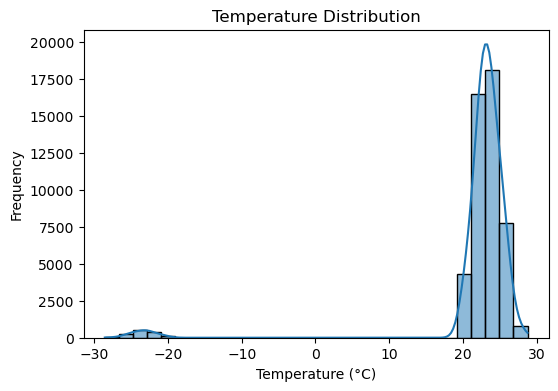

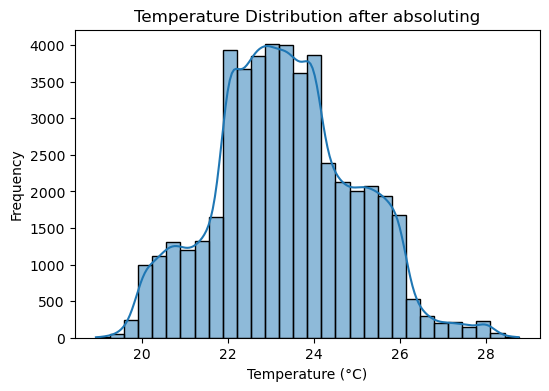


Frequency counts for System Location Code:
System Location Code
Zone_C    7218
Zone_G    7206
Zone_E    7204
Zone_B    7200
Zone_A    7075
Zone_F    7071
Zone_D    7026
Name: count, dtype: int64

Unique values for System Location Code:
['Zone_D' 'Zone_G' 'Zone_F' 'Zone_B' 'Zone_C' 'Zone_A' 'Zone_E']

Frequency counts for Previous Cycle Plant Type:
Previous Cycle Plant Type
fruiting vegetables    12592
leafy greens           12568
vine crops             12459
herbs                  12381
Name: count, dtype: int64

Unique values for Previous Cycle Plant Type:
['herbs' 'vine crops' 'leafy greens' 'fruiting vegetables']

Frequency counts for Plant Type:
Plant Type
fruiting vegetables    12559
herbs                  12528
leafy greens           12502
vine crops             12411
Name: count, dtype: int64

Unique values for Plant Type:
['vine crops' 'herbs' 'fruiting vegetables' 'leafy greens']

Frequency counts for Plant Stage:
Plant Stage
seedling      16854
vegetative    16608
maturity  

In [21]:
# Data cleaning & preprocessing

## 1. Standardize text columns
df['Plant Type'] = df['Plant Type'].str.lower().str.strip()
df['Previous Cycle Plant Type'] = df['Previous Cycle Plant Type'].str.lower().str.strip()
df['Plant Stage'] = df['Plant Stage'].str.lower().str.strip()

## 2. Nutrient columns should be numeric
nutrient_cols = ['Nutrient N Sensor (ppm)', 
                 'Nutrient P Sensor (ppm)', 
                 'Nutrient K Sensor (ppm)'
                 ]
for col in nutrient_cols:
    df[col] = df[col].replace({' ppm': '', 'None': ''}, regex=True)
    df[col] = pd.to_numeric(df[col], errors='coerce')
    
plt.figure(figsize=(6, 4))
sns.histplot(df['Temperature Sensor (°C)'], kde=True, bins=30)
plt.title("Temperature Distribution")
plt.xlabel("Temperature (°C)")
plt.ylabel("Frequency")
plt.show()

## 3. temperature seems to have negative values that are highly likely 
## to be positive values but filled with a negative sign
# convert them to positive values
df['Temperature Sensor (°C)'] = df['Temperature Sensor (°C)'].abs()
plt.figure(figsize=(6, 4))
sns.histplot(df['Temperature Sensor (°C)'], kde=True, bins=30)
plt.title("Temperature Distribution after absoluting")
plt.xlabel("Temperature (°C)")
plt.ylabel("Frequency")
plt.show()

## 4. drop the duplicates
df.drop_duplicates(keep='first', inplace=True)

# Frequency counts for string columns to check for wording errors for catergorical columns
string_columns = ['System Location Code', 'Previous Cycle Plant Type', 'Plant Type', 'Plant Stage']
for col in string_columns:
    print(f"\nFrequency counts for {col}:")
    print(df[col].value_counts())
    print(f"\nUnique values for {col}:")
    print(df[col].unique())

print("\nData cleaning & preprocessing completed.")
print("\nDataFrame Info (After Processing):")
print(df.head(20))
print(df.info())

## 4. Fill in Missing Data
Account for the missing data, handled via:
  - **KNN Imputation** for columns correlated with `Temperature Sensor (°C)`, such as `Humidity Sensor (%)`.
  - **Median Imputation** for columns with weaker correlations or fewer missing values.  

In [23]:
# Correlation Among Numeric Columns
columns_with_lots_of_missing = [
    'Humidity Sensor (%)',
    'Light Intensity Sensor (lux)',
    'Nutrient N Sensor (ppm)',
    'Nutrient P Sensor (ppm)',
    'Nutrient K Sensor (ppm)',
    'Water Level Sensor (mm)'
]

subset_cols = columns_with_lots_of_missing + ['Temperature Sensor (°C)']

# Create a subset DataFrame for correlation analysis
df_subset = df[subset_cols]

#compute the correlation matrix
corr_matrix = df_subset.corr(numeric_only=True)

plt.show()
if "Temperature Sensor (°C)" in corr_matrix.columns:
    temp_corr_series = corr_matrix["Temperature Sensor (°C)"].sort_values(ascending=False)
    print("\nCorrelation with Temperature Sensor (°C):")
    print(temp_corr_series)
else:
    print("\nCould not find 'Temperature Sensor (°C)' in correlation matrix. Check column names.")




Correlation with Temperature Sensor (°C):
Temperature Sensor (°C)         1.000000
Humidity Sensor (%)             0.300137
Light Intensity Sensor (lux)    0.224228
Nutrient P Sensor (ppm)         0.160678
Nutrient N Sensor (ppm)         0.016870
Water Level Sensor (mm)        -0.061870
Nutrient K Sensor (ppm)        -0.231145
Name: Temperature Sensor (°C), dtype: float64


In [24]:
# Columns to use KNNImput
knn_cols = [
    'Temperature Sensor (°C)',     
    'Humidity Sensor (%)',          # 0.30 correlation
    'Light Intensity Sensor (lux)', # 0.22 correlation
    'Nutrient K Sensor (ppm)'       # -0.23 correlation
]

# Columns to just fill median
simple_cols = [
    'Nutrient N Sensor (ppm)', # 0.02 correlation
    'Nutrient P Sensor (ppm)', # 0.16 correlation
    'Water Level Sensor (mm)'  # -0.06 correlation
]

all_cols = knn_cols + simple_cols
df_subset = df[all_cols]

df_knn = df[knn_cols]

# KNNImputer
scaler = StandardScaler()
df_knn_scaled = pd.DataFrame(scaler.fit_transform(df_knn), columns=knn_cols)
knn_imputer = KNNImputer(n_neighbors=5)

# normalise it 
df_knn_imputed_scaled = pd.DataFrame(
    knn_imputer.fit_transform(df_knn_scaled),
    columns=knn_cols
)

# scale back
df_knn_imputed = pd.DataFrame(
    scaler.inverse_transform(df_knn_imputed_scaled),
    columns=knn_cols
)
# SimpleImputer
df_simple = df[simple_cols]
median_imputer = SimpleImputer(strategy='median')
df_simple_imputed = pd.DataFrame(median_imputer.fit_transform(df_simple), columns=simple_cols)

df[knn_cols] = df_knn_imputed[knn_cols]
df[simple_cols] = df_simple_imputed[simple_cols]

print("\nImputation done")
print(df.info())
print(df.head(20))





Imputation done
<class 'pandas.core.frame.DataFrame'>
Index: 50000 entries, 0 to 57488
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   System Location Code          50000 non-null  object 
 1   Previous Cycle Plant Type     50000 non-null  object 
 2   Plant Type                    50000 non-null  object 
 3   Plant Stage                   50000 non-null  object 
 4   Temperature Sensor (°C)       43442 non-null  float64
 5   Humidity Sensor (%)           43442 non-null  float64
 6   Light Intensity Sensor (lux)  43442 non-null  float64
 7   CO2 Sensor (ppm)              50000 non-null  int64  
 8   EC Sensor (dS/m)              50000 non-null  float64
 9   O2 Sensor (ppm)               50000 non-null  int64  
 10  Nutrient N Sensor (ppm)       43442 non-null  float64
 11  Nutrient P Sensor (ppm)       43442 non-null  float64
 12  Nutrient K Sensor (ppm)       43442 non-null  fl



## 4. Visualisation




--- System Location Code ---
Number of unique categories: 7
System Location Code
Zone_B    8296
Zone_G    8287
Zone_E    8272
Zone_C    8268
Zone_F    8156


<Figure size 1200x400 with 0 Axes>


--- Previous Cycle Plant Type ---
Number of unique categories: 4
Previous Cycle Plant Type
Fruiting Vegetables    14481
Leafy Greens           14446
Vine Crops             14305
Herbs                  14257


<Figure size 1200x400 with 0 Axes>


--- Plant Type ---
Number of unique categories: 12
Plant Type
Fruiting Vegetables    10137
Herbs                  10059
Leafy Greens            9968
Vine Crops              9921
leafy greens            2241


<Figure size 1200x400 with 0 Axes>


--- Plant Stage ---
Number of unique categories: 9
Plant Stage
Seedling      13440
Vegetative    13364
Maturity      13330
SEEDLING       3048
seedling       2937


<Figure size 1200x400 with 0 Axes>

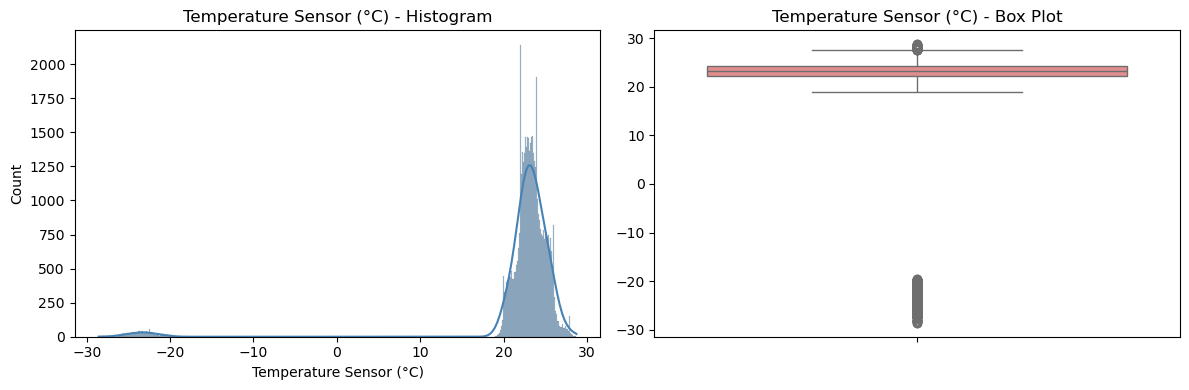

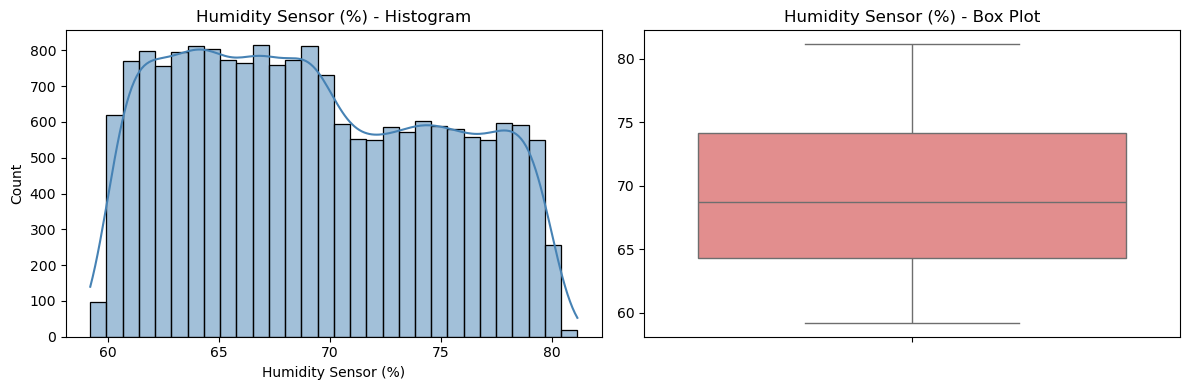

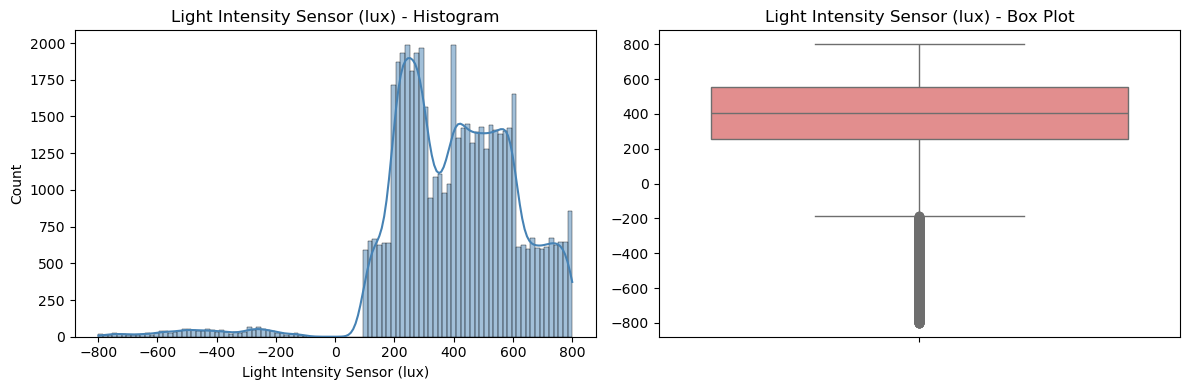

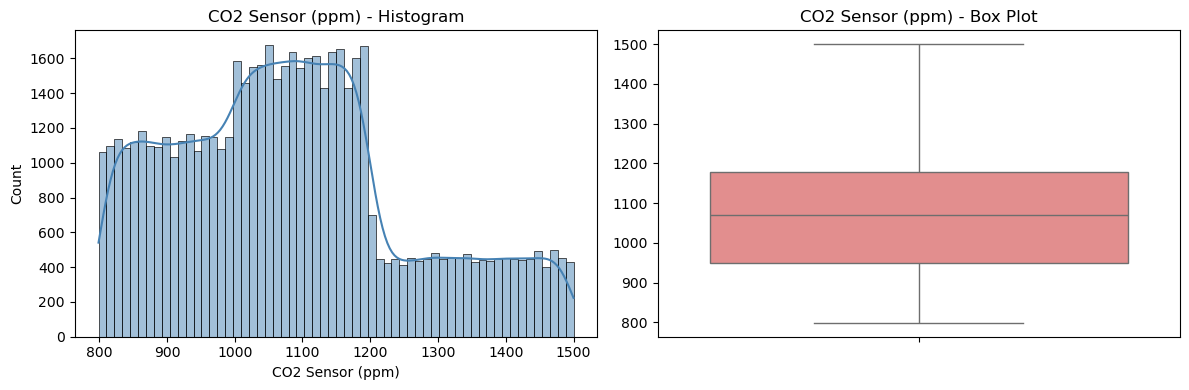

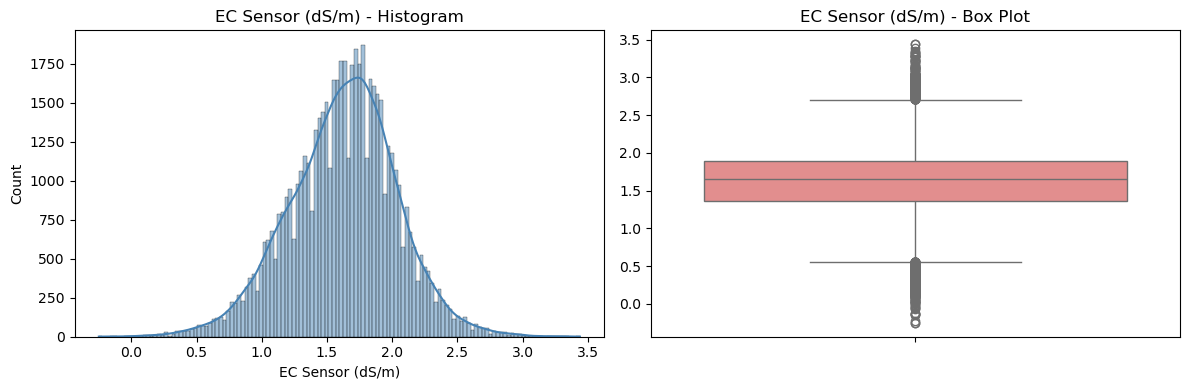

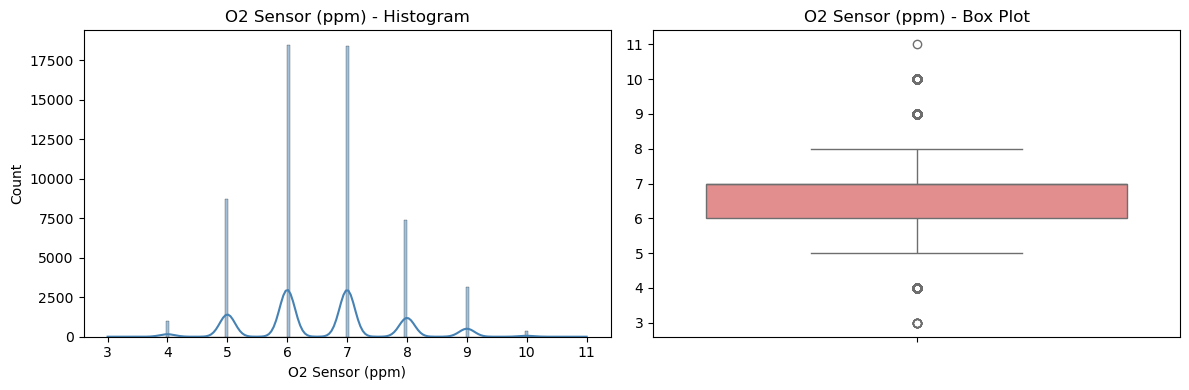


--- Nutrient N Sensor (ppm) ---
Number of unique categories: 322
Nutrient N Sensor (ppm)
150    1351
100     957
200     648
250     456
158     420


<Figure size 1200x400 with 0 Axes>


--- Nutrient P Sensor (ppm) ---
Number of unique categories: 118
Nutrient P Sensor (ppm)
50    2283
30    1813
37    1070
34    1063
33    1061


<Figure size 1200x400 with 0 Axes>


--- Nutrient K Sensor (ppm) ---
Number of unique categories: 395
Nutrient K Sensor (ppm)
200    1214
150     920
250     787
300     624
100     397


<Figure size 1200x400 with 0 Axes>

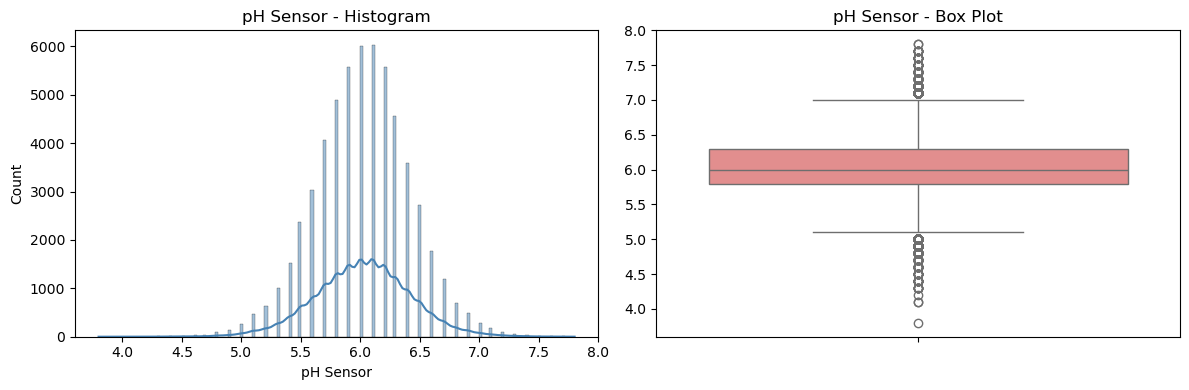

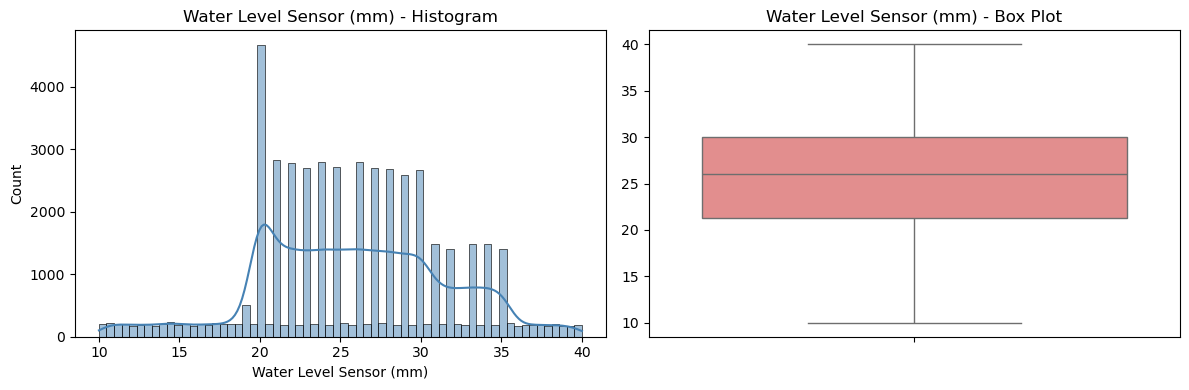

In [17]:
for col in df.columns:
    plt.figure(figsize=(12, 4))
    
    # Check if the column is numeric
    if pd.api.types.is_numeric_dtype(df[col]):
        # Subplot 1: Histogram + KDE
        plt.subplot(1, 2, 1)
        sns.histplot(data=df, x=col, kde=True, color='steelblue')
        plt.title(f'{col} - Histogram')
        plt.xlabel(col)
        plt.ylabel('Count')
        
        # Subplot 2: Box Plot
        plt.subplot(1, 2, 2)
        sns.boxplot(data=df, y=col, color='lightcoral')
        plt.title(f'{col} - Box Plot')
        plt.ylabel('')
        
    else:
            print(f"\n--- {col} ---")
            # Number of unique categories
            unique_count = df[col].nunique()
            print(f"Number of unique categories: {unique_count}")

            print(df[col].value_counts().head().to_string())
    
    plt.tight_layout()
    plt.show()



## 5. EDA



Correlation with Temperature Sensor (°C):
Temperature Sensor (°C)         1.000000
Humidity Sensor (%)             0.256822
Light Intensity Sensor (lux)    0.191998
Nutrient P Sensor (ppm)         0.127603
O2 Sensor (ppm)                 0.007716
CO2 Sensor (ppm)                0.003346
EC Sensor (dS/m)               -0.000378
Nutrient N Sensor (ppm)        -0.001172
Water Level Sensor (mm)        -0.055103
Water Level Sensor (mm)        -0.055103
Nutrient K Sensor (ppm)        -0.233749
Name: Temperature Sensor (°C), dtype: float64

2) Class Distribution:
 Plant Type-Stage
fruiting vegetables-seedling      4318
leafy greens-seedling             4221
leafy greens-maturity             4188
herbs-vegetative                  4179
herbs-maturity                    4175
herbs-seedling                    4174
vine crops-vegetative             4173
fruiting vegetables-vegetative    4163
vine crops-seedling               4141
vine crops-maturity               4097
leafy greens-vegetative     

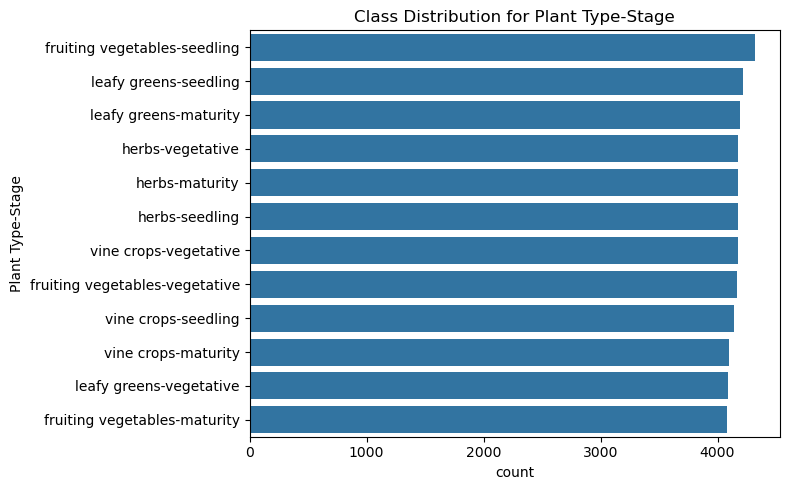


3) Outlier Counts per Numeric Column:
   Humidity Sensor (%): 0 outliers
   Light Intensity Sensor (lux): 971 outliers
   CO2 Sensor (ppm): 0 outliers
   EC Sensor (dS/m): 741 outliers
   O2 Sensor (ppm): 3951 outliers
   Nutrient N Sensor (ppm): 458 outliers
   Nutrient P Sensor (ppm): 0 outliers
   Nutrient K Sensor (ppm): 0 outliers
   Water Level Sensor (mm): 656 outliers
   Water Level Sensor (mm): 656 outliers
   Temperature Sensor (°C): 408 outliers

4) Unique categories:
   Unique Plant Types: 4
   Unique Stages: 3

   Average Temperature by Plant Type-Stage:
Plant Type-Stage
fruiting vegetables-maturity      23.344932
fruiting vegetables-seedling      23.366069
fruiting vegetables-vegetative    23.355114
herbs-maturity                    23.380941
herbs-seedling                    23.348613
herbs-vegetative                  23.280846
leafy greens-maturity             23.329751
leafy greens-seedling             23.328469
leafy greens-vegetative           23.348280
vine crops-m

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)



5) Variance Inflation Factor (VIF) for Numeric Features:
                         Feature         VIF
0            Humidity Sensor (%)  214.325888
1   Light Intensity Sensor (lux)    6.222474
2               CO2 Sensor (ppm)   41.763853
3               EC Sensor (dS/m)   16.669500
4                O2 Sensor (ppm)   35.015867
5        Nutrient N Sensor (ppm)   29.594231
6        Nutrient P Sensor (ppm)   25.121447
7        Nutrient K Sensor (ppm)   21.261819
8        Water Level Sensor (mm)         inf
9        Water Level Sensor (mm)         inf
10       Temperature Sensor (°C)  237.774693


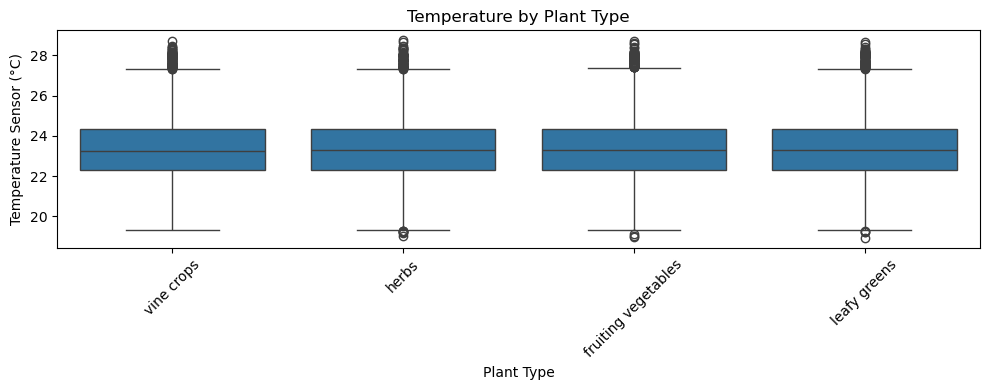

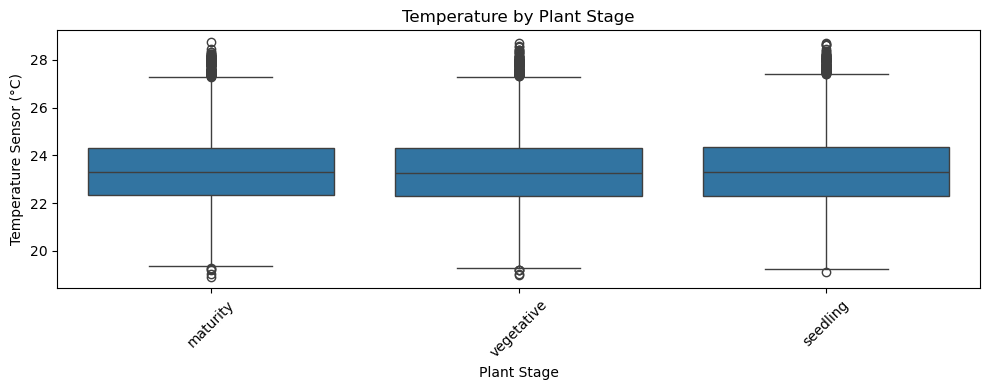

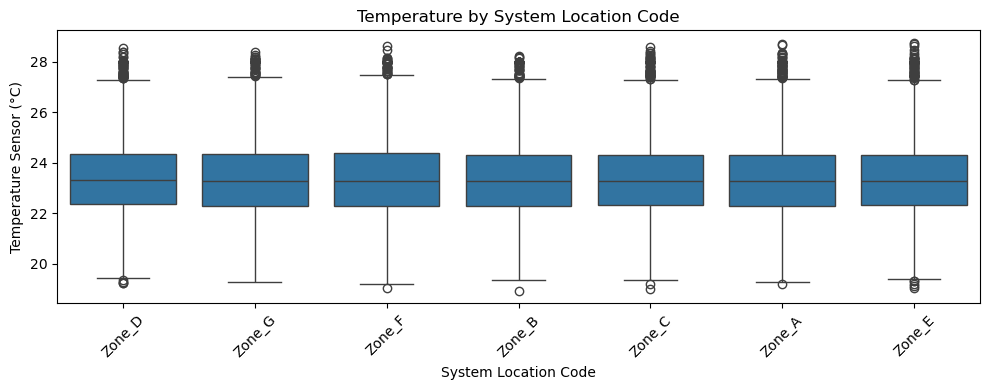

In [27]:
# NEW CORRELATION ANALYSIS WITH TEMPERATURE
numeric_cols = [
    'Humidity Sensor (%)',
    'Light Intensity Sensor (lux)',
    'CO2 Sensor (ppm)',
    'EC Sensor (dS/m)',
    'O2 Sensor (ppm)',
    'Nutrient N Sensor (ppm)',
    'Nutrient P Sensor (ppm)',
    'Nutrient K Sensor (ppm)',
    'Water Level Sensor (mm)',
    'Water Level Sensor (mm)'
]

subset_cols = numeric_cols + ['Temperature Sensor (°C)']

# Create a subset DataFrame for correlation analysis
df_subset = df[subset_cols]

#compute the correlation matrix
corr_matrix = df_subset.corr(numeric_only=True)

plt.show()
if "Temperature Sensor (°C)" in corr_matrix.columns:
    temp_corr_series = corr_matrix["Temperature Sensor (°C)"].sort_values(ascending=False)
    print("\nCorrelation with Temperature Sensor (°C):")
    print(temp_corr_series)
else:
    print("\nCould not find 'Temperature Sensor (°C)' in correlation matrix. Check column names.")

# 2. CLASS DISTRIBUTION & COMBINED TARGET COLUMN
# Create a combined label "Plant Type-Stage" and show its distribution.
df['Plant Type-Stage'] = df['Plant Type'] + '-' + df['Plant Stage']
print("\n2) Class Distribution:\n", df['Plant Type-Stage'].value_counts())

# Plot the count distribution of "Plant Type-Stage".
plt.figure(figsize=(8,5))
sns.countplot(y='Plant Type-Stage',
              data=df,
              order=df['Plant Type-Stage'].value_counts().index)
plt.title("Class Distribution for Plant Type-Stage")
plt.tight_layout()
plt.show()

# detect outliers
# For each numeric column, calculate the number of outliers using IQR * 1.5.
print("\n3) Outlier Counts per Numeric Column:")
for col in subset_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    outlier_count = ((df[col] < (Q1 - 1.5*IQR)) | (df[col] > (Q3 + 1.5*IQR))).sum()
    print(f"   {col}: {outlier_count} outliers")

# check types of plant type and plant stage
print("\n4) Unique categories:")
print("   Unique Plant Types:", df['Plant Type'].nunique())
print("   Unique Stages:", df['Plant Stage'].nunique())

# average temperature by each "Plant Type-Stage".
print("\n   Average Temperature by Plant Type-Stage:")
print(df.groupby('Plant Type-Stage')['Temperature Sensor (°C)'].mean())

# 5. VIF (VARIANCE INFLATION FACTOR)
# Evaluate multicollinearity among numeric columns by calculating VIF.
df_vif = df[subset_cols].dropna().replace([np.inf, -np.inf], np.nan).dropna()

vif = pd.DataFrame()
vif["Feature"] = df_vif.columns
vif["VIF"] = [
    variance_inflation_factor(df_vif.values, i)
    for i in range(df_vif.shape[1])
]
print("\n5) Variance Inflation Factor (VIF) for Numeric Features:")
print(vif)

# Visualize how "Temperature Sensor (°C)" varies across a few key categorical features.
for col in ['Plant Type', 'Plant Stage', 'System Location Code']:
    plt.figure(figsize=(10, 4))
    sns.boxplot(x=df[col], y=df['Temperature Sensor (°C)'])
    plt.xticks(rotation=45)
    plt.title(f"Temperature by {col}")
    plt.tight_layout()
    plt.show()


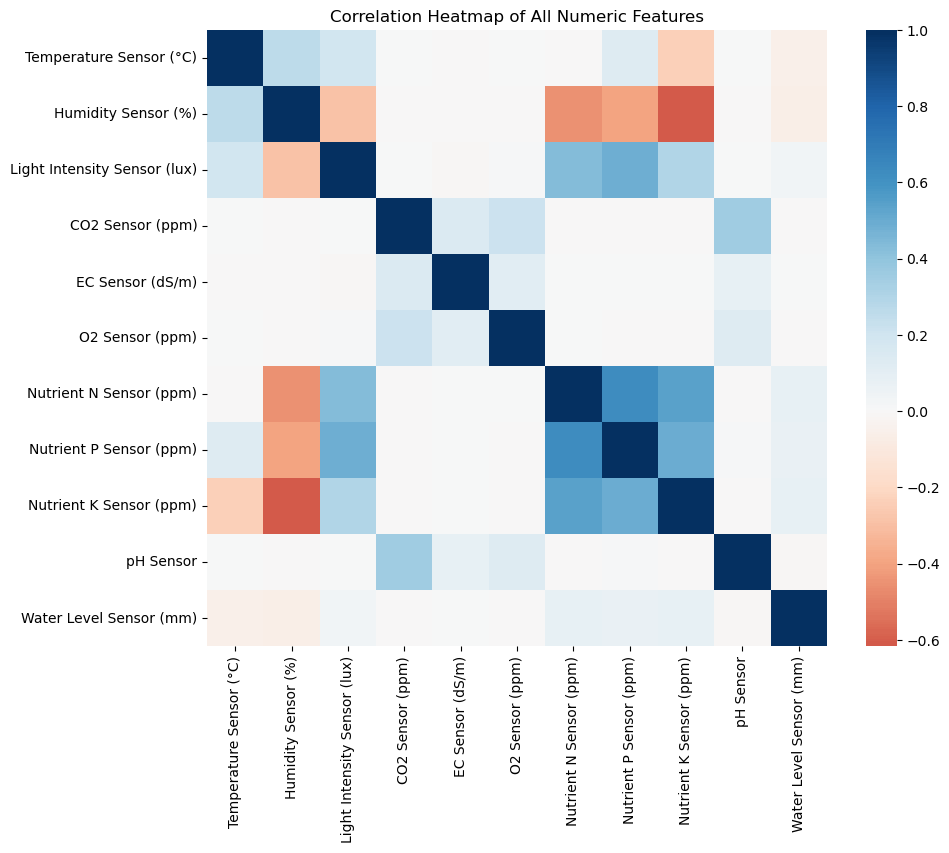

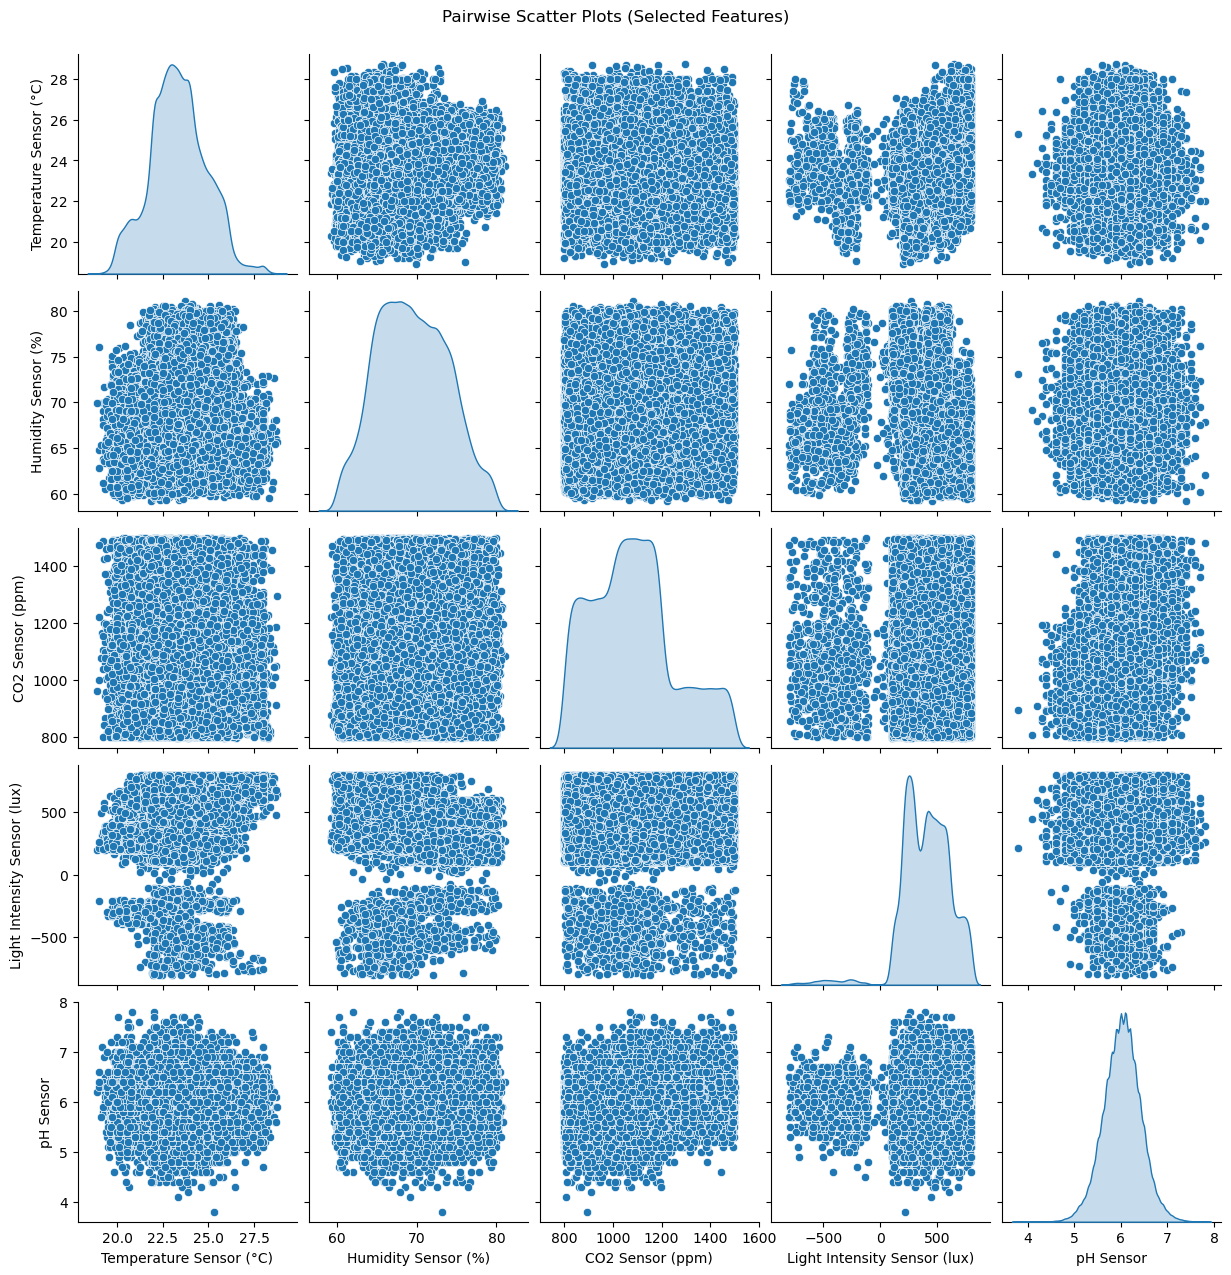

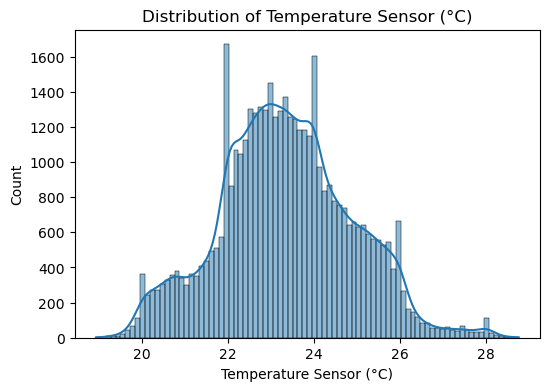

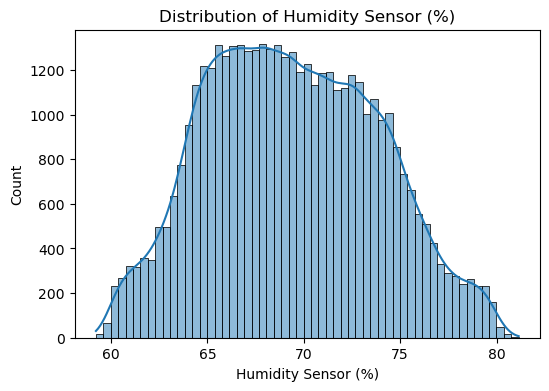

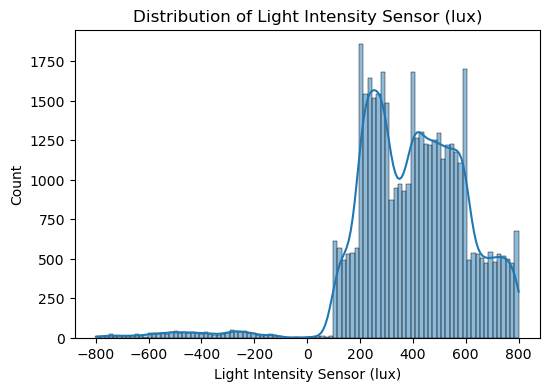

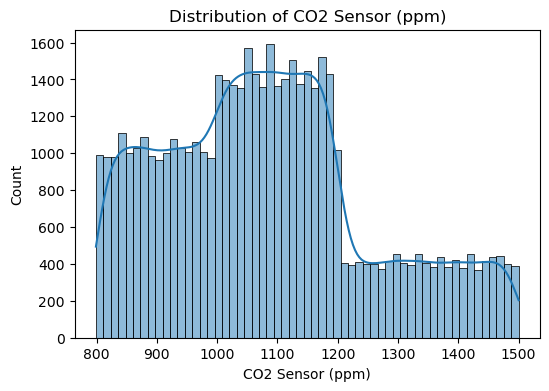

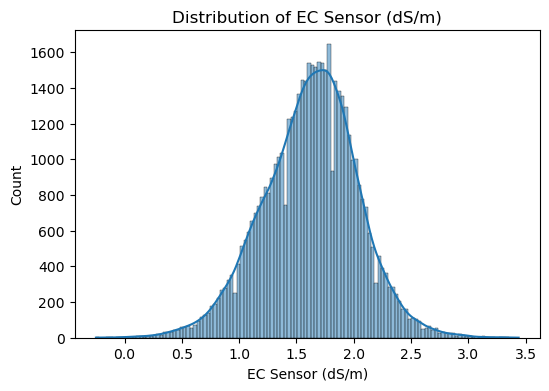

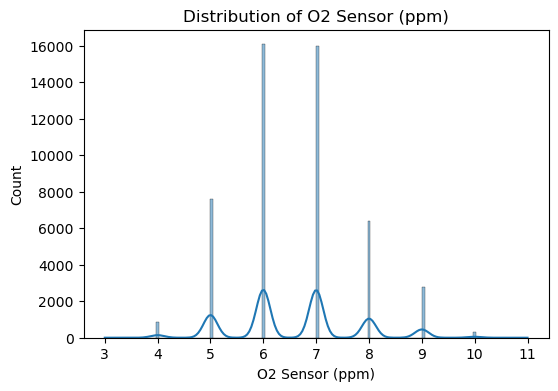

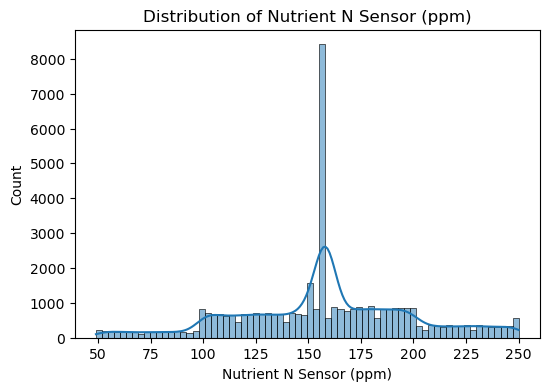

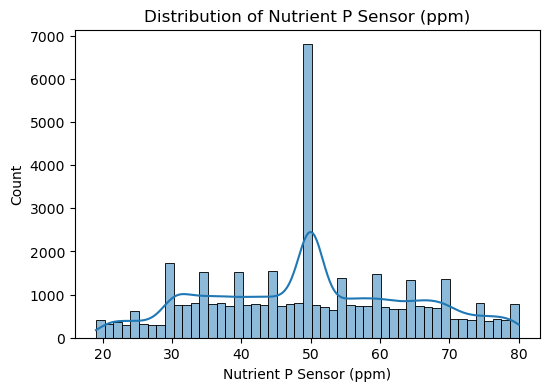

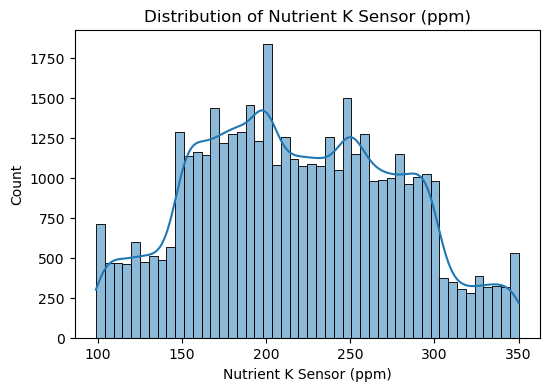

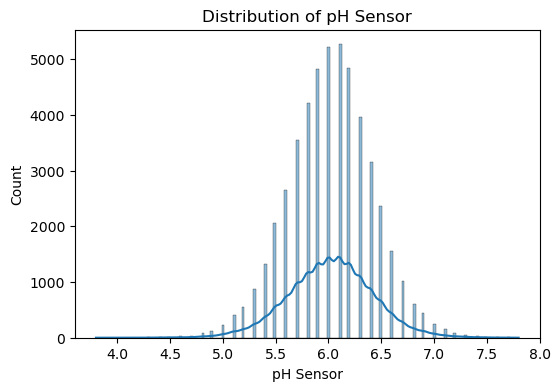

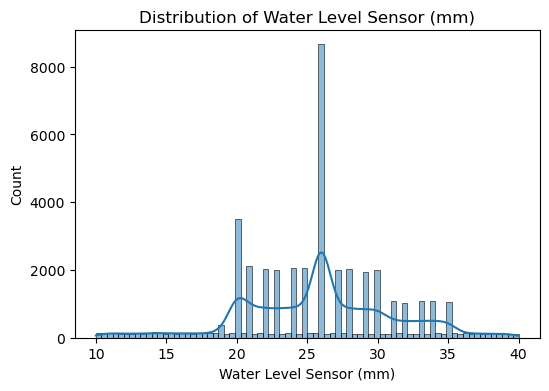


Class Distribution for Plant Type-Stage:
Plant Type-Stage
fruiting vegetables-seedling      4318
leafy greens-seedling             4221
leafy greens-maturity             4188
herbs-vegetative                  4179
herbs-maturity                    4175
herbs-seedling                    4174
vine crops-vegetative             4173
fruiting vegetables-vegetative    4163
vine crops-seedling               4141
vine crops-maturity               4097
leafy greens-vegetative           4093
fruiting vegetables-maturity      4078
Name: count, dtype: int64


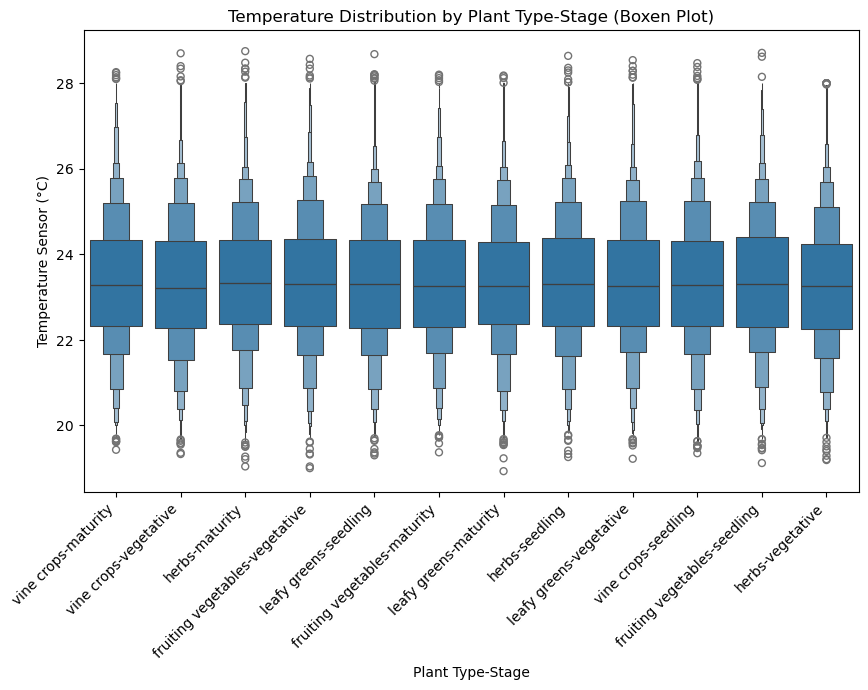

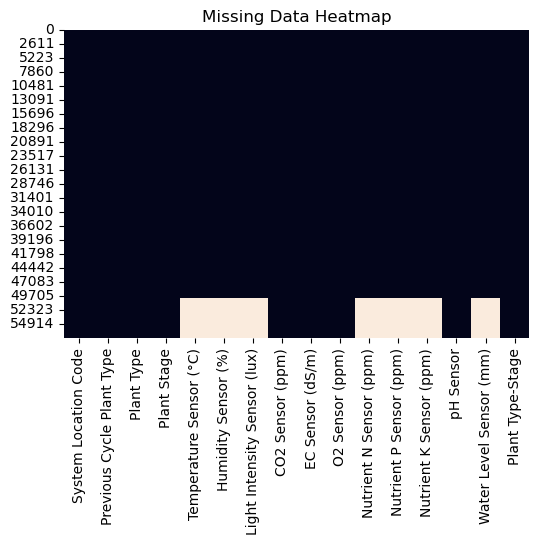


Variance Inflation Factors (VIF):
                         Feature         VIF
0        Temperature Sensor (°C)  247.516897
1            Humidity Sensor (%)  254.484442
2   Light Intensity Sensor (lux)    6.224795
3               CO2 Sensor (ppm)   48.296262
4               EC Sensor (dS/m)   16.745502
5                O2 Sensor (ppm)   35.451014
6        Nutrient N Sensor (ppm)   29.679980
7        Nutrient P Sensor (ppm)   25.121508
8        Nutrient K Sensor (ppm)   22.685546
9                      pH Sensor  214.625724
10       Water Level Sensor (mm)   23.581050


In [28]:
# full correlaiton heatmap
numeric_cols = df.select_dtypes(include=[np.number]).columns
plt.figure(figsize=(10, 8))
corr_matrix = df[numeric_cols].corr()
sns.heatmap(corr_matrix, annot=False, cmap='RdBu', center=0)
plt.title("Correlation Heatmap of All Numeric Features")
plt.show()

# scatter plot matrix for selected features
subset_cols = [
    'Temperature Sensor (°C)',
    'Humidity Sensor (%)',
    'CO2 Sensor (ppm)',
    'Light Intensity Sensor (lux)',
    'pH Sensor'
]
sns.pairplot(df[subset_cols], diag_kind='kde')
plt.suptitle("Pairwise Scatter Plots (Selected Features)", y=1.02)
plt.show()

# 3.distribution/histogram for each numeric column to see skewn  multi-modal patterns
for col in numeric_cols:
    plt.figure(figsize=(6, 4))
    sns.histplot(df[col], kde=True)
    plt.title(f"Distribution of {col}")
    plt.show()

# box plots
df['Plant Type-Stage'] = df['Plant Type'] + '-' + df['Plant Stage']
print("\nClass Distribution for Plant Type-Stage:")
print(df['Plant Type-Stage'].value_counts())

plt.figure(figsize=(10, 6))
sns.boxenplot(x='Plant Type-Stage', y='Temperature Sensor (°C)', data=df)
plt.xticks(rotation=45, ha='right')
plt.title("Temperature Distribution by Plant Type-Stage (Boxen Plot)")
plt.show()
    

# see how many missing values are there
plt.figure(figsize=(6, 4))
sns.heatmap(df.isnull(), cbar=False)
plt.title("Missing Data Heatmap")
plt.show()



## Insights from EDA

### Regression Task (Temperature Prediction)

- **Key Predictors**:  
  EDA revealed moderate correlations between temperature and features like humidity, CO2, and some nutrient sensors.  
  - **Inclusion of Categorical Columns** (e.g., `Plant Type`): Different plant types all have about the same temperature with minnute differences, but still gna include to account for that

- **Distribution of Temperature**:  
  Most temperature readings clustered around ~23°C, but negative or near-zero values indicated data entry errors, corrected via absolute conversion.  
  > **Impact**: Improves model performance by removing invalid data and capturing realistic temperature patterns.

- **Polynomial Features**:  
  Certain sensor relationships might be non-linear. Polynomial expansion can help capture interactions, especially if humidity and nutrient levels affect temperature in complex ways.


### 3. Classification Task (Plant Type-Stage Prediction)

- **Combined Target**:  
  A new feature `PlantTypeStage` (`Plant Type` + `Plant Stage`) was created to define distinct classes. Potential class imbalance, where some plant types/stages are rare.

- **Numeric and Categorical Predictors**:  
  - **Numeric**: Sensor readings like CO2, humidity, and nutrient concentrations.  
  - **Categorical**: `Previous Cycle Plant Type` may correlate with management practices or environmental setups.

- **Class Imbalance**:  
  Some categories have far fewer samples so use **macro F1** scoring in GridSearchCV to ensure minority classes are not overshadowed by majority classes.

- **Outlier Handling**:  
  Box plots showed significant overlaps and outliers across plant type-stages. Capping outliers helps reduce noise and focuses on the core range of sensor readings.

### 4. Model Selection and Hyperparameter Tuning

- **XGBoost**:  
  - **Regression**: Selected for its ability to handle non-linear relationships and outliers effectively.  
  - **Classification**: Robust to imbalanced data (with proper metrics) and handles high-dimensional data well.

- **Parameter Grids**:  
  Based on EDA insights, we experimented with parameters controlling tree depth, learning rate, and regularization (alpha, lambda) to combat potential overfitting, especially given polynomial features.

- **Cross-Validation**:  
  Using `cv=5` ensures each model is tested on multiple folds, mitigating the risk of overfitting to any single partition.


## Conclusions

### Data Overview & Cleaning
- **Initial Data Quality:**  
  - Raw dataset has mixed data types, duplicates, and inconsistent formatting in text fields.
  - Many columns had non-numeric entries (e.g., nutrient sensors) that were cleaned by removing extra characters and converting to numeric types.
  
- **Text Standardization:**  
  - Convert textual fields to lowercase and stripped whitespace to ensure consistency.
  - Frequency counts revealed a reasonable spread of categories, though some categories are less frequent, which may affect modeling.

- **Handling of Temperature Values:**  
  - Negative temperature values were converted to absolute values, assuming they were data entry errors as negative values seem to be all within 20-30 degree celcius which is the normal temperature
  - This correction resulted in a more realistic distribution of temperature readings.

- **Handling of Duplicated Values**
  - Removed duplicated values so they do not skew the prediction

### Missing Data and Imputation
- **Missingness Patterns:**  
  - Some sensor readings (e.g, humidity, light intensity) contained missing values.
  - A correlation analysis helped in deciding the imputation strategy:
    - **KNN Imputation** was used for columns with stronger relationships to temperature (e.g., humidity, light intensity, nutrient K).
    - **Median Imputation** was applied to columns where the correlation was weaker (e.g., nutrient N, nutrient P, water level).

### Exploratory Visualizations & Statistical Analysis
- **Distribution Analysis:**  
  - Histograms and KDE plots for temperature and other numeric features revealed that most variables are roughly normally distributed after cleaning, though some exhibit skewness or outliers.
  - Box plots further identified outlier presence, prompting the use of outlier capping techniques.

- **Correlation Insights:**  
  - The correlation matrix showed that temperature is only very slightly correlated with certain features (e.g., humidity).
  - This insight informs feature selection, suggesting that these features may be ok predictors in the regression model.

- **Outlier Detection:**  
  - The IQR method identified a number of outliers in various sensor readings.
  - Recognizing these outliers justifies the use of outlier capping to mitigate their influence on the modeling process.

- **Multicollinearity (VIF):**  
  - Variance Inflation Factor (VIF) analysis indicated that some numeric features are moderately correlated.
  - This insight can guide further feature engineering or dimensionality reduction to avoid multicollinearity in the predictive models.

### Combined Target Analysis (For Classification)
- **Plant Type-Stage Distribution:**  
  - A combined target column (`Plant Type-Stage`) was created, and its distribution shows class imbalances.
  - This observation is critical for the classification task as it might require balancing techniques or specific evaluation metrics.

### Overall Impact on Modeling
- **Informed Preprocessing:**  
  - The EDA provided a clear rationale for using scaling, imputation, and outlier capping in the preprocessing pipeline.
- **Feature Selection:**  
  - Correlation and outlier analysis directly informed which features to prioritize when building regression and classification models.
- **Model Configuration:**  
  - Understanding the data distributions and relationships aids in hyperparameter tuning and selection of appropriate evaluation metrics for both tasks.
